In [30]:
#Imports
import xarray as xr
import sys
sys.path.append('/home/563/rl5183/Functions')
import model_functions as func
import os
import pandas as pd
import numpy as np
import scipy
from scipy import signal
import iris
import iris.analysis.stats as istats
from importlib import reload
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
func=reload(func)

In [32]:
#Historical model runs
hist_temp = func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/ts/gr1.5/')
hist_precip = func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/pr/gr1.5/')

GISS-E2-2-G path does not exist
MIROC-ES2L path does not exist
FIO-ESM-2-0 path does not exist
HadGEM3-GC31-MM path does not exist
HadGEM3-GC31-LL path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
EC-Earth3-LR path does not exist
NorESM1-F path does not exist
IITM-ESM path does not exist
45 model paths found and stored in models dictionary
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/ts/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/ts/gr1.5/v20190630/*.nc
MCM-UA-1-0 /g/data/lp01/CMIP6/CMIP/UA/MCM-UA-1-0/historical/r1i1p1f1/Amon/ts/gr1.5/v20190731/*.nc
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/ts/gr1.5/v20190919/*.nc
MPI-ESM1-2-HR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/ts/gr1.5/v20190710/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historic

In [33]:
#Future model runs
future_temp = func.read_future_models('/g/data/lp01/CMIP6/ScenarioMIP/', '/ssp585/r1i1p1f1/Amon/ts/gr1.5/')
future_precip = func.read_future_models('/g/data/lp01/CMIP6/ScenarioMIP/', '/ssp585/r1i1p1f1/Amon/pr/gr1.5/')

MPI-ESM-1-2-HAM path does not exist
MCM-UA-1-0 path does not exist
MIROC-ES2L path does not exist
FIO-ESM-2-0 path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
29 model paths found and stored in models dictionary
NESM3 /g/data/lp01/CMIP6/ScenarioMIP/NUIST/NESM3/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190728/*.nc
ACCESS-CM2 /g/data/lp01/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190924/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190119/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20191013/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190818/*.nc
BCC-CSM2-MR /g/data/lp01/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v201903

In [34]:
#Find common models between all four datasets
hist_temp = hist_temp.where(hist_temp.model.isin(hist_precip.model), drop = True)
hist_temp = hist_temp.where(hist_temp.model.isin(future_temp.model), drop = True)
hist_temp = hist_temp.where(hist_temp.model.isin(future_precip.model), drop = True)
hist_precip = hist_precip.where(hist_precip.model.isin(hist_temp.model), drop = True)
future_temp = future_temp.where(future_temp.model.isin(hist_temp.model), drop = True)
future_precip = future_precip.where(future_precip.model.isin(hist_temp.model), drop = True)

In [35]:
#Detrend future temp data
future_ts_data = future_temp.ts

future_ts_dt = np.apply_along_axis(scipy.signal.detrend, 1, future_ts_data)

future_ts = xr.DataArray(future_ts_dt, coords=future_ts_data.coords, attrs=future_ts_data.attrs)

In [36]:
#Detrend historical temp data
hist_ts_data = hist_temp.ts

hist_ts_dt = np.apply_along_axis(scipy.signal.detrend, 1, hist_ts_data)

hist_ts = xr.DataArray(hist_ts_dt, coords=hist_ts_data.coords, attrs=hist_ts_data.attrs)

In [37]:
#precip
hist_pr = hist_precip.pr
future_pr = future_precip.pr

In [38]:
#discard models rejected by model evaluation
future_ts = future_ts.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
hist_ts = hist_ts.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
future_pr = future_pr.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
hist_pr = hist_pr.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])

In [39]:
#sort models alphabetically
future_ts = future_ts.sortby('model')
hist_ts = hist_ts.sortby('model')
future_pr = future_pr.sortby('model')
hist_pr = hist_pr.sortby('model')

In [40]:
#30 year climatology for comparison 
future_clim_ts = future_ts.sel(time=slice('2070-01', '2099-12'))
hist_clim_ts = hist_ts.sel(time=slice('1970-01', '1999-12'))
hist_clim_pr = hist_pr.sel(time=slice('1970-01','1999-12'))
hist_clim_pr = hist_pr*86400
future_clim_pr = future_pr.sel(time=slice('2070-01','2099-12'))
future_clim_pr = future_clim_pr*86400

### Spatial Corr over Aus

In [41]:
#Landmask
landmask_ds = xr.open_dataset('/g/data/eg3/pfd548/gridarea/land-sea_mask/fractional_land.1.5-deg.nc')
landmask = landmask_ds.mean(dim='time')

In [42]:
#Precip aus
future_pr_aus = future_clim_pr.sel(lon = slice(112, 156)).sel(lat=slice(-44, -10))
#Nino34 index
nino34_list = []

for m in future_clim_ts.model:
    nino34_list.append(func.nino34_clim(future_clim_ts.sel(model=m)))
    
nino34 = xr.concat(nino34_list, dim='model')

In [43]:
#Spatial corr DJF
pearson_list_djf = []

for m in future_pr_aus.model:
    pearson_list_djf.append(func.spatial_corr_future_clim(future_pr_aus.sel(model=m), nino34.sel(model=m), 'DJF'))

pearson_djf = xr.DataArray(pearson_list_djf, dims=['model', 'lat', 'lon'])
pearson_djf.coords['model'] = future_pr_aus.model.values
pearson_djf.coords['lat'] = future_pr_aus.lat.values
pearson_djf.coords['lon'] = future_pr_aus.lon.values

pearson_djf = pearson_djf.where(landmask.data==1)

#Spatial corr SON
pearson_list_son = []

for m in future_pr_aus.model:
    pearson_list_son.append(func.spatial_corr_future_clim(future_pr_aus.sel(model=m), nino34.sel(model=m), 'SON'))

pearson_son = xr.DataArray(pearson_list_son, dims=['model', 'lat', 'lon'])
pearson_son.coords['model'] = future_pr_aus.model.values
pearson_son.coords['lat'] = future_pr_aus.lat.values
pearson_son.coords['lon'] = future_pr_aus.lon.values

pearson_son = pearson_son.where(landmask.data==1)

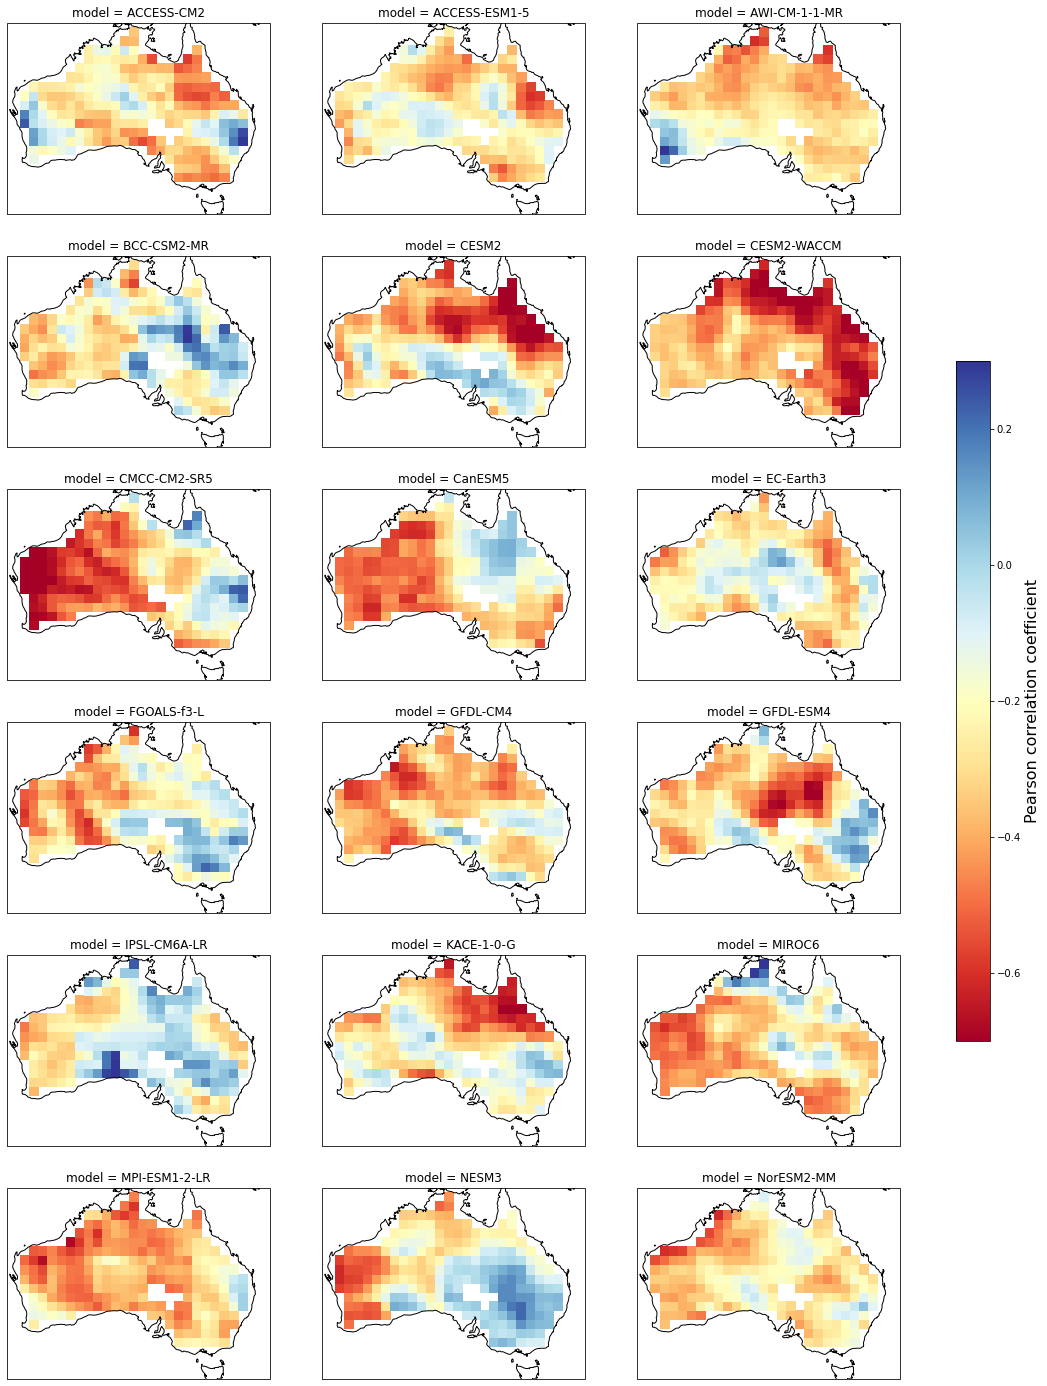

In [50]:
#Plots DJF
fig = plt.figure(figsize=(20,25))
axs = []

columns = 3
rows = 6

vmin = -0.7
vmax = 0.3

for i, m in enumerate(pearson_djf.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([112.5, 156, -40.75, -11.25])
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pearson_djf.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdYlBu')
    ax.coastlines()
    
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('Pearson correlation coefficient', fontsize=16)

#plt.savefig('spatial_corr_djf_future.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

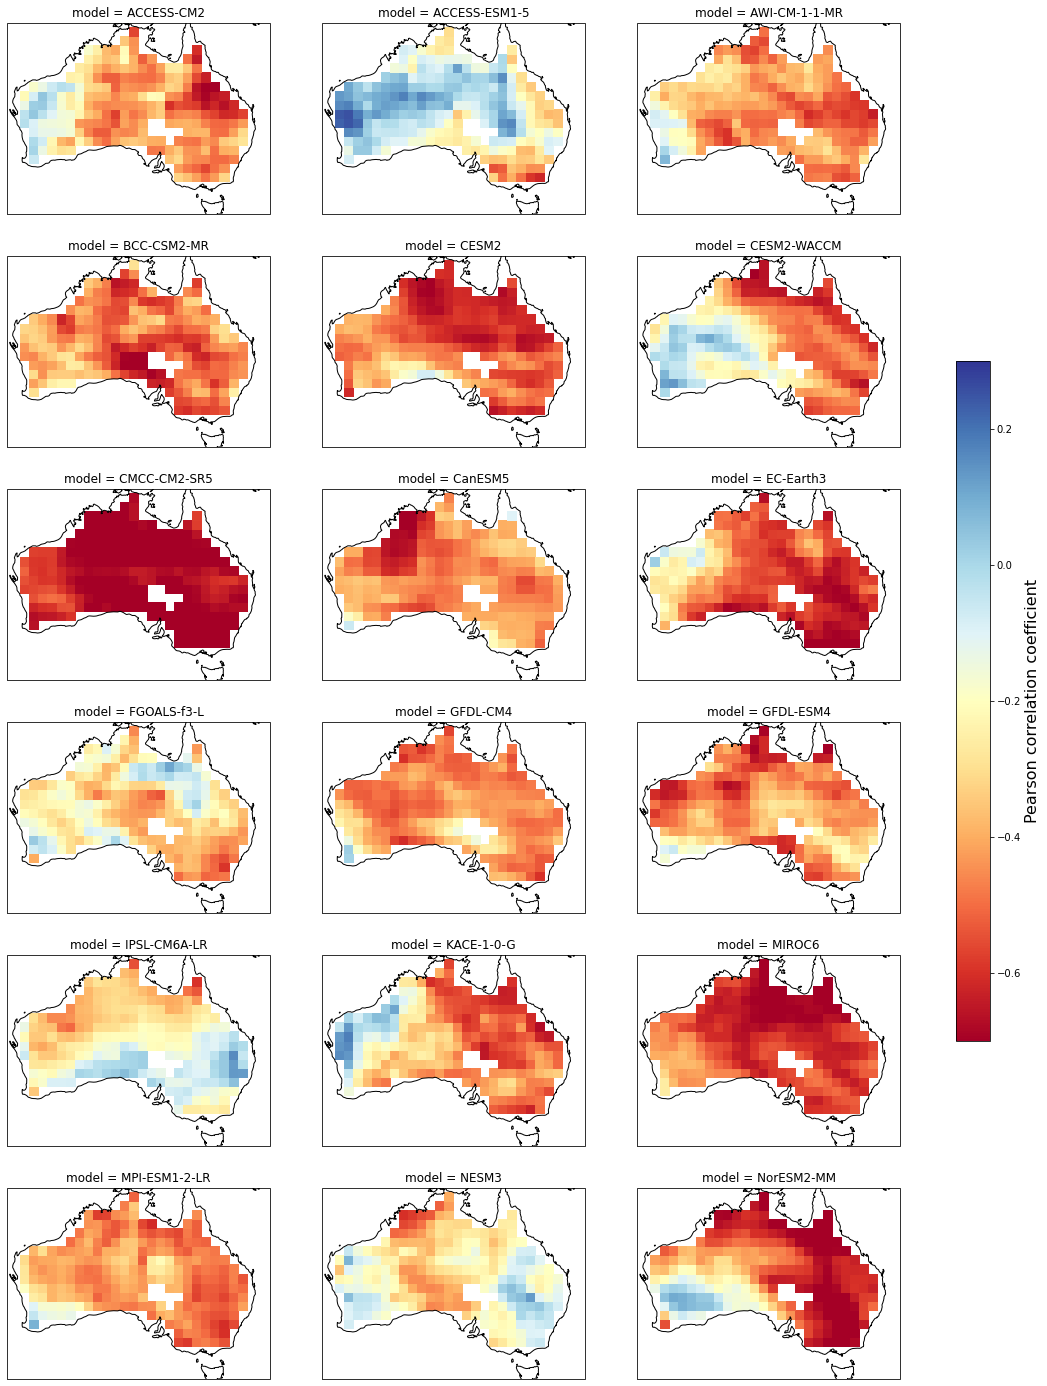

In [51]:
#Plots SON
fig = plt.figure(figsize=(20,25))
axs = []

columns = 3
rows = 6

vmin = -0.7
vmax = 0.3

for i, m in enumerate(pearson_son.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([112.5, 156, -40.75, -11.25])
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pearson_son.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdYlBu')
    ax.coastlines()
    
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('Pearson correlation coefficient', fontsize=16)

#plt.savefig('spatial_corr_son_future.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')